# `Boruta` usage demonstration

In [1]:
import logging
import typing as t

import numpy as np
import pandas as pd
import seaborn as sns
import shap
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from Boruta import Boruta, TrialData, setup_logger

In [2]:
np.random.seed(666)

In [3]:
def plot_imp_history(df_history: pd.DataFrame):
    sns.lineplot(x='Step', y='Importance', hue='Feature', data=df_history)
    sns.lineplot(x='Step', y='Threshold', data=df_history, linestyle='--', linewidth=4)

## Basic usage

### Single objective, `RandomForestClassifier`, default paramters

In [4]:
x, y = make_classification(50, 10, n_informative=2)
boruta = Boruta()
boruta.fit(x, y);

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

- Turn on logging to get a glimpse on what's going on

In [5]:
logger = setup_logger(stdout_level=logging.DEBUG, logger=logging.getLogger('Boruta'))

In [6]:
boruta = Boruta(verbose=2)
boruta.fit(x, y);

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

2022-05-18 16:26:26,288 INFO [Boruta--_fit]: Trial 1: sampled trial data with shapes x_train: (35, 20), y_train: (35,), x_test: (15, 20), y_test: (15,)
2022-05-18 16:26:26,429 INFO [Boruta--_fit]: 30.0% (3) recorded as hits
2022-05-18 16:26:26,437 INFO [Boruta--_report_trial]: Out of 10: {'accepted': 0, 'rejected': 0, 'tentative': 10}
2022-05-18 16:26:26,438 INFO [Boruta--_report_trial]: Total summary: {'accepted': 0, 'rejected': 0, 'tentative': 10}
2022-05-18 16:26:26,443 INFO [Boruta--_fit]: Trial 2: sampled trial data with shapes x_train: (35, 20), y_train: (35,), x_test: (15, 20), y_test: (15,)
2022-05-18 16:26:26,547 INFO [Boruta--_fit]: 30.0% (3) recorded as hits
2022-05-18 16:26:26,554 INFO [Boruta--_report_trial]: Out of 10: {'accepted': 0, 'rejected': 0, 'tentative': 10}
2022-05-18 16:26:26,555 INFO [Boruta--_report_trial]: Total summary: {'accepted': 0, 'rejected': 0, 'tentative': 10}
2022-05-18 16:26:26,560 INFO [Boruta--_fit]: Trial 3: sampled trial data with shapes x_train

- Get a final report based on feature selection history

In [7]:
boruta.report_features(full=True)

2022-05-18 16:26:28,781 INFO [Boruta--report_features]: Stopped at 20 step. Final results: {'accepted': 3, 'rejected': 6, 'tentative': 1}
2022-05-18 16:26:28,785 INFO [Boruta--report_features]: Feature 1 was marked at step 8 and threshold 0.02 as Accepted, having 0.08 importance ({'min': 0.06, 'max': 0.13, 'median': 0.1, 'mean': 0.1, 'std': 0.03}) and total number of hits 8
2022-05-18 16:26:28,787 INFO [Boruta--report_features]: Feature 10 was marked at step 8 and threshold 0.02 as Rejected, having 0.01 importance ({'min': 0.0, 'max': 0.02, 'median': 0.01, 'mean': 0.01, 'std': 0.01}) and total number of hits 0
2022-05-18 16:26:28,789 INFO [Boruta--report_features]: Feature 2 was marked at step 8 and threshold 0.02 as Rejected, having 0.01 importance ({'min': 0.0, 'max': 0.02, 'median': 0.01, 'mean': 0.01, 'std': 0.01}) and total number of hits 0
2022-05-18 16:26:28,791 INFO [Boruta--report_features]: Feature 3 was marked at step 8 and threshold 0.02 as Accepted, having 0.12 importance 

- Access features

In [8]:
features = boruta.features_
features.accepted, features.rejected, features.tentative

(array(['1', '3', '8'], dtype=object),
 array(['2', '4', '5', '6', '9', '10'], dtype=object),
 array(['7'], dtype=object))

- Check out history

In [9]:
df = features.history
print(df.shape)
df.head()

(200, 6)


,Feature,Step,Importance,Hit,Decision,Threshold
0,1,1,0.111843,1,Tentative,0.027119
1,1,2,0.055041,1,Tentative,0.038128
2,1,3,0.126531,1,Tentative,0.022964
3,1,4,0.126792,1,Tentative,0.020175
4,1,5,0.068284,1,Tentative,0.035565


Note that `n_rows = n_steps * n_features`. `df.dropna()` cleans the table giving access to the last step for a feature where it was used.b

In [10]:
df.dropna().groupby('Feature').tail(1)

,Feature,Step,Importance,Hit,Decision,Threshold
7,1,8,0.080301,1,Accepted,0.021711
27,2,8,0.010837,0,Rejected,0.021711
47,3,8,0.117011,1,Accepted,0.021711
67,4,8,0.016653,0,Rejected,0.021711
95,5,16,0.020386,0,Rejected,0.107105
107,6,8,0.008141,0,Rejected,0.021711
139,7,20,0.055813,0,Tentative,0.089430
147,8,8,0.100241,1,Accepted,0.021711
167,9,8,0.006432,0,Rejected,0.021711
187,10,8,0.012079,0,Rejected,0.021711


- Query history to inspect the selection process

In [11]:
df[df['Feature'] == '7']

,Feature,Step,Importance,Hit,Decision,Threshold
120,7,1,0.01379,0,Tentative,0.027119
121,7,2,0.007527,0,Tentative,0.038128
122,7,3,0.029413,1,Tentative,0.022964
123,7,4,0.004463,0,Tentative,0.020175
124,7,5,0.021633,0,Tentative,0.035565
125,7,6,0.010612,0,Tentative,0.028946
126,7,7,0.016462,0,Tentative,0.046986
127,7,8,0.019231,0,Tentative,0.021711
128,7,9,0.082186,0,Tentative,0.098748
129,7,10,0.064249,1,Tentative,0.045085


- One can use history to produce plots

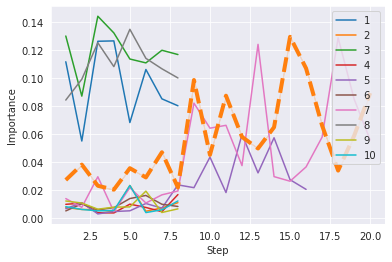

In [12]:
plot_imp_history(df)

- Lower percentile threshold

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

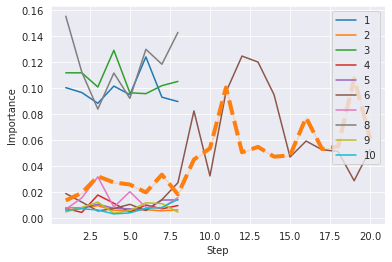

In [13]:
boruta = Boruta(percentile=90)
boruta.fit(x, y)
plot_imp_history(boruta.features_.history)

- Apply rough fix

This won't overwrite existing `boruta.features_` but will return a new `Features` instance. In the latter, the history will remain unchanged, but the `accepted`, `rejected`, and `tentative` attributes will be modified accordingly.

In [14]:
fs = boruta.rough_fix(n_last_steps=10)

In [15]:
fs.accepted, fs.rejected, fs.tentative

(array(['1', '3', '8'], dtype=object),
 array(['2', '4', '5', '6', '7', '9', '10'], dtype=object),
 array([], dtype=object))

- Standardize feature importance values

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

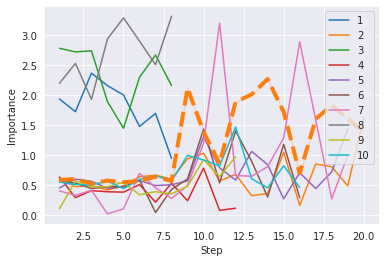

In [16]:
boruta = Boruta(percentile=95, standardize_imp=True)
boruta.fit(x, y)
plot_imp_history(boruta.features_.history)

- Use full dataset to compute shap importance

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

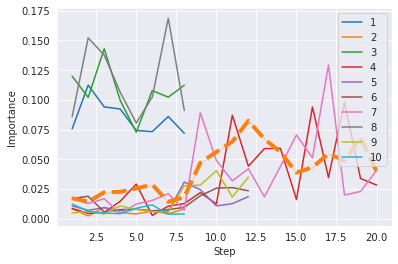

In [17]:
boruta = Boruta(percentile=95, shap_approximate=False, use_test=False)
boruta.fit(x, y)
plot_imp_history(boruta.features_.history)

## Advanced usage

### Different models

In principle, the model can be __any__ callable defining a `fit` method -- classifier or regressor -- as long as the importance calculation is defined.
Note that one can define the latte manually (see below).

For instance, we'll use the `XGBClassifier` and `CatBoostClassifier` below.

In [18]:
x, y = make_classification(500, 10, n_informative=5)

- `XGBClassifier`

Boruta trials:   0%|          | 0/40 [00:00<?, ?it/s]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

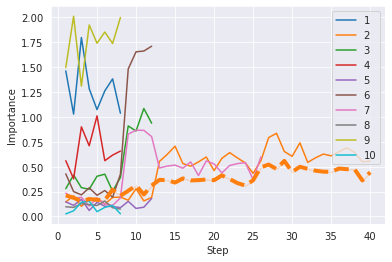

In [19]:
boruta = Boruta(n_iter=40, percentile=95)
boruta.fit(x, y, model=XGBClassifier(n_estimators=20, verbosity=0))
plot_imp_history(boruta.features_.history)

- `CatBoostClassifier`

Boruta trials:   0%|          | 0/40 [00:00<?, ?it/s]

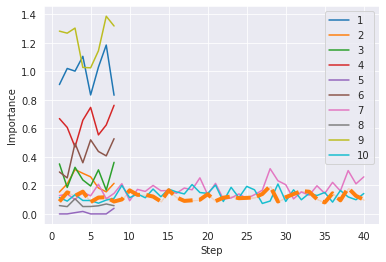

In [20]:
# shap with `approximate` is not supported for catboost currently
boruta = Boruta(n_iter=40, percentile=95, shap_approximate=False)
boruta.fit(x, y, model=CatBoostClassifier(iterations=20, verbose=False))
plot_imp_history(boruta.features_.history)

- `CatBoostClassifier` with categorical features

Boruta trials:   0%|          | 0/40 [00:00<?, ?it/s]

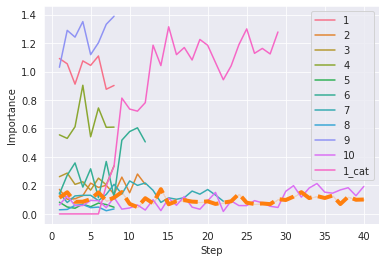

In [21]:
x_cat = boruta.dataset_.x.copy()
x_cat['1_cat'] = pd.Series(x_cat['1'].round(0).astype(int).astype('category'))

boruta = Boruta(n_iter=40, percentile=95, shap_approximate=False)
boruta.fit(x_cat, y, model=CatBoostClassifier(iterations=20, verbose=False))
plot_imp_history(boruta.features_.history)

- Custom importance measure

Any callable accepting an estimator or estimator together with the `TrialData` object and returning a numpy array with shape `(n_test_features, )` will work.

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

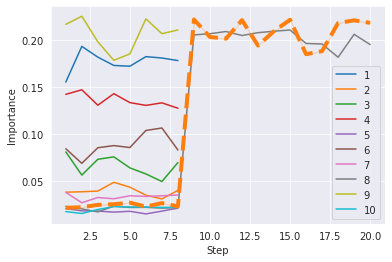

In [22]:
def get_imp(estimator):
    # equivalent to the builtin importance getter
    return estimator.feature_importances_

boruta = Boruta(n_iter=20, shap_importance=False, importance_getter=get_imp)
boruta.fit(x, y)
plot_imp_history(boruta.features_.history)

Boruta trials:   0%|          | 0/40 [00:00<?, ?it/s]

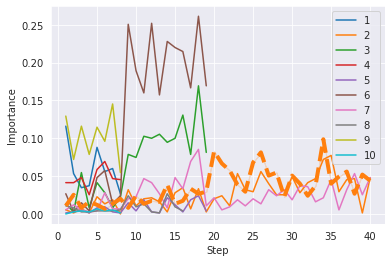

In [23]:
def get_permutation_imp(estimator: t.Any, trial_data: TrialData) -> np.ndarray:
    imp = permutation_importance(estimator, trial_data.x_test, trial_data.y_test, scoring='accuracy', n_jobs=-1)
    return np.array(imp['importances_mean'])

# Let's also use a different estimator with all cars, just for the sake of it
boruta = Boruta(n_iter=40, shap_importance=False, use_test=False, importance_getter=get_permutation_imp)
boruta.fit(x, y, model=ExtraTreesClassifier(n_estimators=20))
plot_imp_history(boruta.features_.history)

- Non-ensemble classifier with custom importance evaluation

Boruta trials:   0%|          | 0/40 [00:00<?, ?it/s]

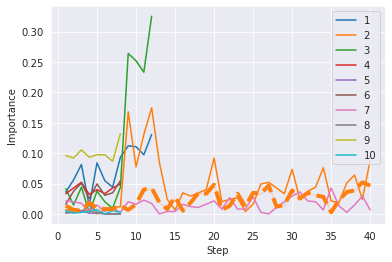

In [24]:
boruta = Boruta(n_iter=40, shap_importance=False, use_test=False, importance_getter=get_permutation_imp)
boruta.fit(x, y, model=LogisticRegression())
plot_imp_history(boruta.features_.history)

- Multiple objectives

Built-in approach is basically averaging importance of each feature per objective.
One can define a different aggregation strategy via custom importance getter.

In [25]:
x, y = make_classification(500, 10, n_informative=2)
# copy classes to create multiple binary objective variables
y = np.array([[y_, y_] for y_ in y])

Boruta trials:   0%|          | 0/40 [00:00<?, ?it/s]

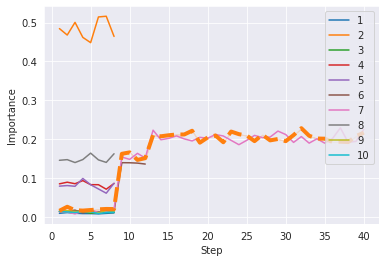

In [26]:
# Using built-in importance
boruta = Boruta(n_iter=40, use_test=False, shap_importance=False)
boruta.fit(x, y)
plot_imp_history(boruta.features_.history)

Boruta trials:   0%|          | 0/40 [00:00<?, ?it/s]

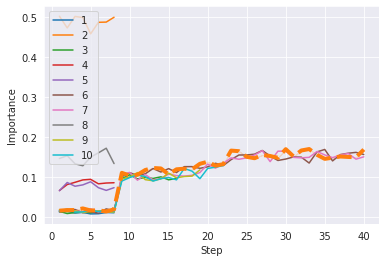

In [27]:
# Using shap importance
boruta.fit(x, y)
plot_imp_history(boruta.features_.history)

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

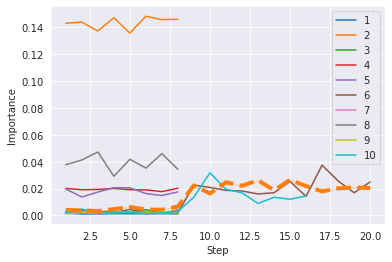

In [28]:
# Using custom aggregation
def get_imp(estimator, trial_data: TrialData):
    # equivalent to the builtin importance getter
    explainer = shap.explainers.Tree(estimator)
    imp = explainer.shap_values(trial_data.x_test, approximate=False)
    imp = np.max(np.vstack([np.abs(v).mean(0) for v in imp]), axis=0)
    return imp


boruta = Boruta(n_iter=20, shap_importance=False, importance_getter=get_imp)
boruta.fit(x, y)
plot_imp_history(boruta.features_.history)